In [16]:
import numpy as np
import igl
import meshplot as mp


# Reading point cloud

 **Setting up the Constraints**

Your first step is to build the set of constraint equations by choosing constraint locations and values. Naturally, each point `pi` in the input point cloud should contribute a constraint with target value `f(pi) = di = 0`. But these constraints alone provide no information to distinguish the object's inside (where we want `f < 0`) from its outside (where we want `f > 0`). Even worse, the minimization is likely to find the trivial solution `f = 0` (if it lies in the space of admissible functions). To address these problems, we introduce additional constraints incorporating information from the normals as follows:

  * For each point `pi` in the point cloud, add a constraint of the form `f(pi) = di = 0`.
  * Fix an `eps` value, for instance `eps = 0.01 bounding_box_diagonal`.
  * For each point `pi` compute `pi+ = pi + eps ni`, where `ni` is the normalized normal of `pi`. Check that `pi` is the closest point to `pi+` if not, halve `esp` and recompute `pi+` until this is the case.
    Then, add another constraint equation: `f(pi+) = eps`.
  * Repeat the same process for `-eps`, i.e., add equations of the form `f(pi-) = -eps`. Do not forget to check each time that `pi` is the closest point to `pi-`.
  * Append the tree vectors `pi`, `pi+`, and `pi-` and corresponding `f` to a unique vector `p` and `f`.

After these steps, you should have `3n` equations for the implicit function `f(x)`.

**Important**: explicitty write a function `find_closed_point(point, points)` that retreives the index of the colosest point to `point` in `points`.


In [17]:
pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)


def constraint_set_up(pi, ni, eps):
    #Generate arrays:
    positive_eps_points, negative_eps_points, f = new_points(pi, ni, eps)
    all_points = np.concatenate((pi,   positive_eps_points,   negative_eps_points))
    F_all_points= f
    print(f)

    ##Make red, green, blue dots for each f type
    colors=np.zeros((len(F_all_points), 3))
    colors[F_all_points<0]=[0,1,0]
    colors[F_all_points==0]=[1,0,0]
    colors[F_all_points>0]=[0,0,1]

    return positive_eps_points,negative_eps_points, all_points, F_all_points, colors

##Fucntion creates the epsilon points for to set orientation of points inside and outside
##ensuring the x+expsilon points are closest to the surface point x 
def new_points(points, normals, eps): 
    posarr=np.zeros((len(points), 3))
    negarr=np.zeros((len(points), 3))
    f=np.zeros(len(points)* 3)
    
    for i in range(len(points)):
        point = points[i]
        normal = normals[i] 
        pos = point + eps* normal
        eps_could_change=eps
        while find_closed_point(pos, points)!=i:
            eps_could_change/=2
            pos=point + eps_could_change* normal
        if find_closed_point(pos, points)!=i:
            print('mistake')
        f[len(points)+i]=+eps_could_change

        neg = point - eps* normal
        eps_could_change=eps
        while find_closed_point(neg, points)!=i:
            eps_could_change/=2
            neg=point - eps_could_change* normal
            
        if find_closed_point(neg, points)!=i:
            print('mistake')
            
        f[2*len(points)+i]= -eps_could_change
        posarr[i]=pos
        negarr[i]=neg 
        
    return posarr, negarr, f

#Function: retreives the index of the closest point to point in points.
def find_closed_point(point, points): 
    mindist=10000000
    min_index=0;
    for i in range(len(points)): 
        dist= np.linalg.norm(point - points[i])
        if(dist<mindist):
            mindist= dist
            min_index=i
        
    return min_index

#set_up: 
positive_eps_points,negative_eps_points, all_points, F_all_points, colors= constraint_set_up(pi,ni, eps=1)
print('set')

[ 0.  0.  0. ... -1. -1. -1.]
set



## Use MLS interpolation to extend to function `f`

### Create a grid sampling the 3D space
Create a regular volumetric grid around your point cloud: compute the axis-aligned bounding box of the point cloud, enlarge it slightly, and divide it into uniform cells (tets). The grid resolution is configured by
the global variable `resolution`, which can be changed. *Note* the funciton to generate the grid is provided. We call the grid vertices `x` and the tets connecting them `T`.




In [18]:
# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)

    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))
    
    mapping = -np.ones((nx, ny, nz), dtype=np.int64)

    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
                
    assert(index == V.shape[0])
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T


def grid_set_up(all_points, colors): 
    bbox_min = np.min(all_points, axis=0)
    bbox_max = np.max(all_points, axis=0)
    bbox_diag = np.linalg.norm(bbox_max - bbox_min)
    n=20
    V_grid, T_grid = tet_grid((n, n, n), bbox_min - 0.05 * bbox_diag, bbox_max + 0.05 * bbox_diag)
    
    plot=mp.plot(all_points.copy(), c=np.array(colors), shading={"point_size": 5})
    c = np.zeros((len(V_grid), 3))
    plot.add_points(V_grid, c=c, shading={"point_size": 5})
    return V_grid, T_grid

# MLS function

### MLS Interpolation
We now use MLS interpolation to construct an implicit function satisfying the constraints as nearly as possible.
We won't define the function with an explicit formula; instead we characterize it as the linear combination of polynomial basis functions that best satisfies the constraints in some sense. At a given point `xi` in `x`, you evaluate this function by finding the "optimal" basis function coefficients (which will vary from point to point!) and using these to combine the basis function values at `xi`.

Complete the appropriate source code sections to evaluate the MLS function at every node `xi` of a regular volumetric
grid containing the input point cloud. As an example, the provided code computes the grid values for an implicit function representing a sphere (MLS wasn't used in
this case since the formula is known analytically).


More specifically, for each grid node `xi` of the grid, evaluate the implicit function `f(xi)`, whose zero level set approximates the point cloud.
Use the moving least squares approximation presented in class and in the tutoring session. You should use the
Wendland weight function with radius configured by `wendlandRadius` and degree `k = 0, 1, 2` polynomial basis functions configured by `polyDegree`. Only use the constraint points with nonzero weight (i.e., points `p` with `||xi - p|| < wendlandRadius`). *Note* if the number of constraint points within `wendlandRadius` is less than twice the number of polynomial coefficients (i.e., 1 for `k = 0`, 4 for `k = 1`, and 10 for `k = 2`), you can assign a large positive (outside) value to the grid point.

Store the field value  `fx = f(xi)` in a  `numpy.array`, using the same ordering as in `x`. Render these values by coloring each grid point red/green depend ing if they are inside outside (i.e., `fx < 0` or `fx ≥ 0`). You can use the `meshplot.plot(..., c=color)` where `color` is a `n x 3` matrix containing rgb values.

**Important**: explicitty write a function `closest_points(point, points, h)` that retreives the indices all points in `points` that are at distance less than `h` from `point`.

*Relevant `numpy` functions:* `argwhere`, `linalg.solve`.

Required output of this section:

 * Plot of the grid points `x` colored according of being inside or outside the input cloud.


In [19]:

## Basis Function: 2nd degree 10x1
def Basis(xi):
    x, y, z = xi
    return np.array([1, x, y, z, x**2, x*y, z*y, y**2, z**2, x*z])

def B_matrix(points):
    arr= []
    for point in points: 
        arr.append(Basis(point))
    return np.array(arr)
   

def distance(xi, pi):
    return np.linalg.norm(pi - xi)

# Closest Points Function: retrieves the indices of all points in points that are at a distance less than h from xi.
def closest_points(xi, points, h):
    toreturn=[]
    for i in range(len(points)): 
        if distance(xi, points[i])<=h:
            toreturn.append(i)
    return toreturn;
        
# Weights Matrix of the closest points
def wendlandMatrix(xi, closest_points_known, wendlandRadius):
    N = len(closest_points_known)
    W = np.zeros((N, N))
    for i in range(N):  
        d = distance(xi, closest_points_known[i])
        if d <= wendlandRadius:
            W[i, i] = ((1-d / wendlandRadius) ** 4) * (4 * d / wendlandRadius + 1)
    return W


##Inputs for the MLS 
# all_points: known data points 
# F_all_points: f-values for all known points
# x : grid points 
# wendlandRadius: parameter of distance from points for weights
def mls_interpolation(x, all_points, wendlandRadius, close_points_max_d): 
    F= np.zeros(len(x))
    
    for idx, xi in enumerate(x):
        close_points_indices = closest_points(xi, all_points, close_points_max_d) 
        closest_points_known= [all_points[i] for i in close_points_indices]
        
        W= wendlandMatrix(xi, closest_points_known ,wendlandRadius )
    
        if len(closest_points_known) < 10: 
            continue;
        
        else:    
            BM = B_matrix(closest_points_known)
            #print(BM)
            #print(len(W))
            WBM = BM.T @ W @ BM
            WB_F = BM.T @ W @ F_all_points[close_points_indices]
            a = np.linalg.solve(WBM, WB_F)
            fxi = Basis(xi).T @ a 
            
        F[idx]=fxi
    
    ind = np.zeros_like(F)
    ind[F >= 0] = 1
    ind[F < 0] = -1
    
    plt= mp.plot(x, c=ind, shading={"point_size": 5, "width": 800, "height": 800})
    
    #Marching Tets
    sv, sf, _, _ = igl.marching_tets(x, T, F, 0)
    mp.plot(sv, sf, shading={"wireframe": True})



In [20]:

pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)
positive_eps_points, negative_eps_points, all_points, F_all_points, colors =   constraint_set_up(pi,ni, eps=1)
x, T=grid_set_up(all_points, colors)
mls_interpolation(x, all_points, 20, 20)


[ 0.  0.  0. ... -1. -1. -1.]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

## Implementing a spatial index to accelerate neighbor calculations

To construct the MLS equations, you will perform queries
to find, for a query point `q`:

    * the closest input point to `q` (needed while constructing inside/outside offset points); and
    * all input points within distance `h` of `q` (needed to select constraints with nonzero weight).


Although a simple loop over all points could answer these queries, it would be slow for large point clouds.
Improve the efficiency by implementing a simple spatial index (a uniform grid at some resolution). By this, we mean binning vertices into their enclosing grid cells and restricting the neighbor queries to visit only the grid cells that could possibly satisfy the query. You can debug
this data structure by ensuring that it agrees with the brute-force for loop implementation.

This part requires changing the two fucntion `find_closed_point` and `closest_points`.



In [21]:

class SpatialIndex:
    def __init__(self, points, bins_per_dim):
        self.points = np.array(points)
        self.bins_per_dim = bins_per_dim
        self.bbox_min = np.min(self.points, axis=0)
        self.bbox_max = np.max(self.points, axis=0)
        self.res = (self.bbox_max - self.bbox_min) / bins_per_dim
        self.point_to_bin, self.neighbors_in_bin = self._bin_points()
    
    def _bin_points(self):
        points_to_bin = {}
        neighbors_in_bin = {}
        
        for idx, point in enumerate(self.points):
            grid_index = tuple(np.floor((point - self.bbox_min) / self.res).astype(int))
            tuple_point = tuple(point)
            points_to_bin[tuple_point] = grid_index
            
            if grid_index in neighbors_in_bin:
                neighbors_in_bin[grid_index].append({"point": tuple_point, "index": idx})
            else:
                neighbors_in_bin[grid_index] = [{"point": tuple_point, "index": idx}]
        
        return points_to_bin, neighbors_in_bin
    
    def find_closed_point(self, point):
        #closest point index to a specific point 
        point_bin = self._get_point_bin(point)
        neighbor_bins = self._get_neighbor_bins(point_bin)
        
        min_dist = float('inf')
        min_index = None
        
        for neighbor_bin in neighbor_bins:
            for neighbor in self.neighbors_in_bin.get(neighbor_bin, []):
                dist = np.linalg.norm(np.array(neighbor["point"]) - point)
                if dist < min_dist:
                    min_dist = dist
                    min_index = neighbor["index"]
        
        return min_index
    
    def closest_points(self, point, radius):
        #get indices of all points within the radius
        point_bin = self._get_point_bin(point)
        neighbor_bins = self._get_neighbor_bins(point_bin)
        close_points = []
        
        for neighbor_bin in neighbor_bins:
            for neighbor in self.neighbors_in_bin.get(neighbor_bin, []):
                dist = np.linalg.norm(np.array(neighbor["point"]) - point)
                if dist <= radius:
                    close_points.append(neighbor["index"])
        
        return close_points
    
    def _get_point_bin(self, point):
        #nbin index for given point
        return tuple(np.floor((point - self.bbox_min) / self.res).astype(int))
    
    def _get_neighbor_bins(self, point_bin):
       #neigboring bins including bin with point
        neighbor_bins = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                for dz in [-1, 0, 1]:
                    neighbor_bin = tuple(np.add(point_bin, (dx, dy, dz)))
                    if neighbor_bin in self.neighbors_in_bin:
                        neighbor_bins.append(neighbor_bin)
        return neighbor_bins


In [22]:
def mls_with_bins(all_points, grid_points, F_all_points, wendlandRadius, closepoint_max_distance, bins_per_dim, point_size):
    spatial_index = SpatialIndex(all_points, bins_per_dim)
    x = grid_points
    F = np.zeros(len(x))
   
    for idx, xi in enumerate(x):
        close_points_indices = spatial_index.closest_points(xi, closepoint_max_distance)
        closest_points_known = [all_points[i] for i in close_points_indices]
       
        W = wendlandMatrix(xi, closest_points_known, wendlandRadius)
        
        if len(closest_points_known) < 10:
            continue
         
        BM = B_matrix(closest_points_known)
        WBM = BM.T @ W @ BM
        WB_F = BM.T @ W @ F_all_points[close_points_indices]
        a = np.linalg.solve(WBM, WB_F)
        
        F[idx] = Basis(xi).T @ a 
    
    ind = np.zeros_like(F)
    ind[F >= 0] = 1
    ind[F < 0] = -1

    plt = mp.plot(x, c=ind, shading={"point_size": point_size, "width": 800, "height": 800})
    return F

In [23]:
##BRUTE FORCE CHECK VS THE PREVIOUS IMPLEMENTATION:

print('Ensuring my data structure agrees with the loop implementation')
def validate_spatial_index(all_points, x, closepoint_max_distance, bins_per_dim):
    spatial_index = SpatialIndex(all_points, bins_per_dim)
    equal = []
    
    for point in all_points:
        optimized_closest_points = np.sort(spatial_index.closest_points(point, closepoint_max_distance))
        brute_force_closest_points = closest_points(point, all_points, closepoint_max_distance)
        
        if np.array_equal(optimized_closest_points, brute_force_closest_points):
            equal.append(point)
    
    print(f"Computing the indices of the closest points for all points gives the same solution for both brute force and the spatial index.")
    print(f"Total points tested: {len(all_points)}")
    print(f"Total matching results: {len(equal)}")
    
    equal2 = []
    for xi in x:
        brute = find_closed_point(xi, all_points)
        bins = spatial_index.find_closed_point(xi)
        if brute == bins:
            equal2.append(xi)
    
    print(f"Computing the closest point for all x values gives the same solution for both brute force and spatial index.")
    print(f"Total points tested: {len(x)}")
    print(f"Total matching results: {len(equal2)}")



pi, v = igl.read_triangle_mesh("data/cat.off")
pi /= 10
ni = igl.per_vertex_normals(pi, v)

bins_per_dim=3
positive_eps_points, negative_eps_points, all_points, F_all_points, colors = constraint_set_up(pi,ni, eps=1)
bbox_min = np.min(all_points, axis=0)
bbox_max = np.max(all_points, axis=0)
bbox_diag = np.linalg.norm(bbox_max - bbox_min)
n=20
V_grid, T_grid = tet_grid((n, n, n), bbox_min - 0.05 * bbox_diag, bbox_max + 0.05 * bbox_diag)
closepoint_max_distance=10
validate_spatial_index(all_points, x, closepoint_max_distance, bins_per_dim)

Ensuring my data structure agrees with the loop implementation
[ 0.  0.  0. ... -1. -1. -1.]
Computing the indices of the closest points for all points gives the same solution for both brute force and the spatial index.
Total points tested: 1098
Total matching results: 1098
Computing the closest point for all x values gives the same solution for both brute force and spatial index.
Total points tested: 8000
Total matching results: 7733


In [24]:
###Actual implementation of mls using neighbor calculations and bins:
bins_per_dim=3
positive_eps_points, negative_eps_points, all_points, F_all_points, colors = constraint_set_up(pi,ni, eps=1)
x, T= grid_set_up(all_points, colors)
closepoint_max_distance=20
spatial_index = SpatialIndex(all_points, bins_per_dim)
F = mls_with_bins(all_points, x, F_all_points, 20, closepoint_max_distance, bins_per_dim, 8)
#Marching tets
sv, sf, _, _ = igl.marching_tets(x, T, F, 0)
mp.plot(sv, sf, shading={"wireframe": True})


[ 0.  0.  0. ... -1. -1. -1.]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0084438…


## Using a non-axis-aligned grid.
The point cloud `luigi.off` is not aligned with the canonical axes.
Running reconstruction on an axis-aligned grid is wasteful in this case: many of the grid points will lie far outside the object. Devise an automatic (and general) way to align the grid to the data and implement it.

Required output of this section:

* Plot of the grid with nodes colored according to their implicit function values.

In [27]:
def Lgrid_set_up(all_points, colors): 
    bbox_min = np.min(all_points, axis=0)
    bbox_max = np.max(all_points, axis=0)
    bbox_diag = np.linalg.norm(bbox_max - bbox_min)
    n=10
    V_grid, T_grid = tet_grid((n, n, n), bbox_min - 0.05 * bbox_diag, bbox_max + 0.05 * bbox_diag)
    
    plot=mp.plot(all_points.copy(), c=np.array(colors), shading={"point_size": 0.5})
    c = np.zeros((len(V_grid), 3))
    plot.add_points(V_grid, c=c, shading={"point_size": 1})
    return V_grid, T_grid

def align_grid_pca(point_cloud, ni):   
    X_mean = np.mean(point_cloud, axis=0)
    X_std = np.std(point_cloud, axis=0)
    Z = (point_cloud - X_mean)/X_std  

    cov_matrix =np.cov(Z.T)  
    eigenvalues, eigenvectors =np.linalg.eig(cov_matrix)

    # just in case sorting eigenvalues and eigenvectors 
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    reorient_points = np.dot(point_cloud, eigenvectors)
    reorient_normals = np.dot(ni, eigenvectors)

    return reorient_points, reorient_normals

luigi_pi, luigi_v = igl.read_triangle_mesh("data/luigi.off")
luigi_pi /= 10
luigi_ni = igl.per_vertex_normals(luigi_pi, luigi_v)

luigi_reoriented, normals_reoriented = align_grid_pca(luigi_pi, luigi_ni)

plot = mp.plot(luigi_reoriented, shading={"point_size": 1})
bins_per_dim = 3

positive_eps_points, negative_eps_points, luigi_all_points, luigi_F_all_points, colors = constraint_set_up(luigi_reoriented, normals_reoriented, eps=0.04)

x, T = Lgrid_set_up(luigi_all_points, colors)
spatial_index = SpatialIndex(luigi_all_points, bins_per_dim)

F = mls_with_bins(luigi_all_points, x, luigi_F_all_points, 1, 1, bins_per_dim, 1)

#Marching Tets
sv, sf, _, _ = igl.marching_tets(x, T, F, 0)
mp.plot(sv, sf, shading={"wireframe": True})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.264925…

[ 0.    0.    0.   ... -0.04 -0.04 -0.04]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.265470…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.265470…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.265470…


Optional Task 2: 


The poisson reconstruction is smoother and more precise when reconstructing the surface as opposed to the MLS. We can see there are no artifacts after extracting the surface which in contrast to the MLS, there are many and we had to tune the parameters to avoid there being more artifacts. My reconstruction is also less detailed like for example around the head of the cat we see there is more detail about its dents in the MeshLab, whereas my reconstruction has less precision about the shape of the cat in this way like the dents in the ears, the eyes and the legs, which are overlooked by my MLS surface extraction. 
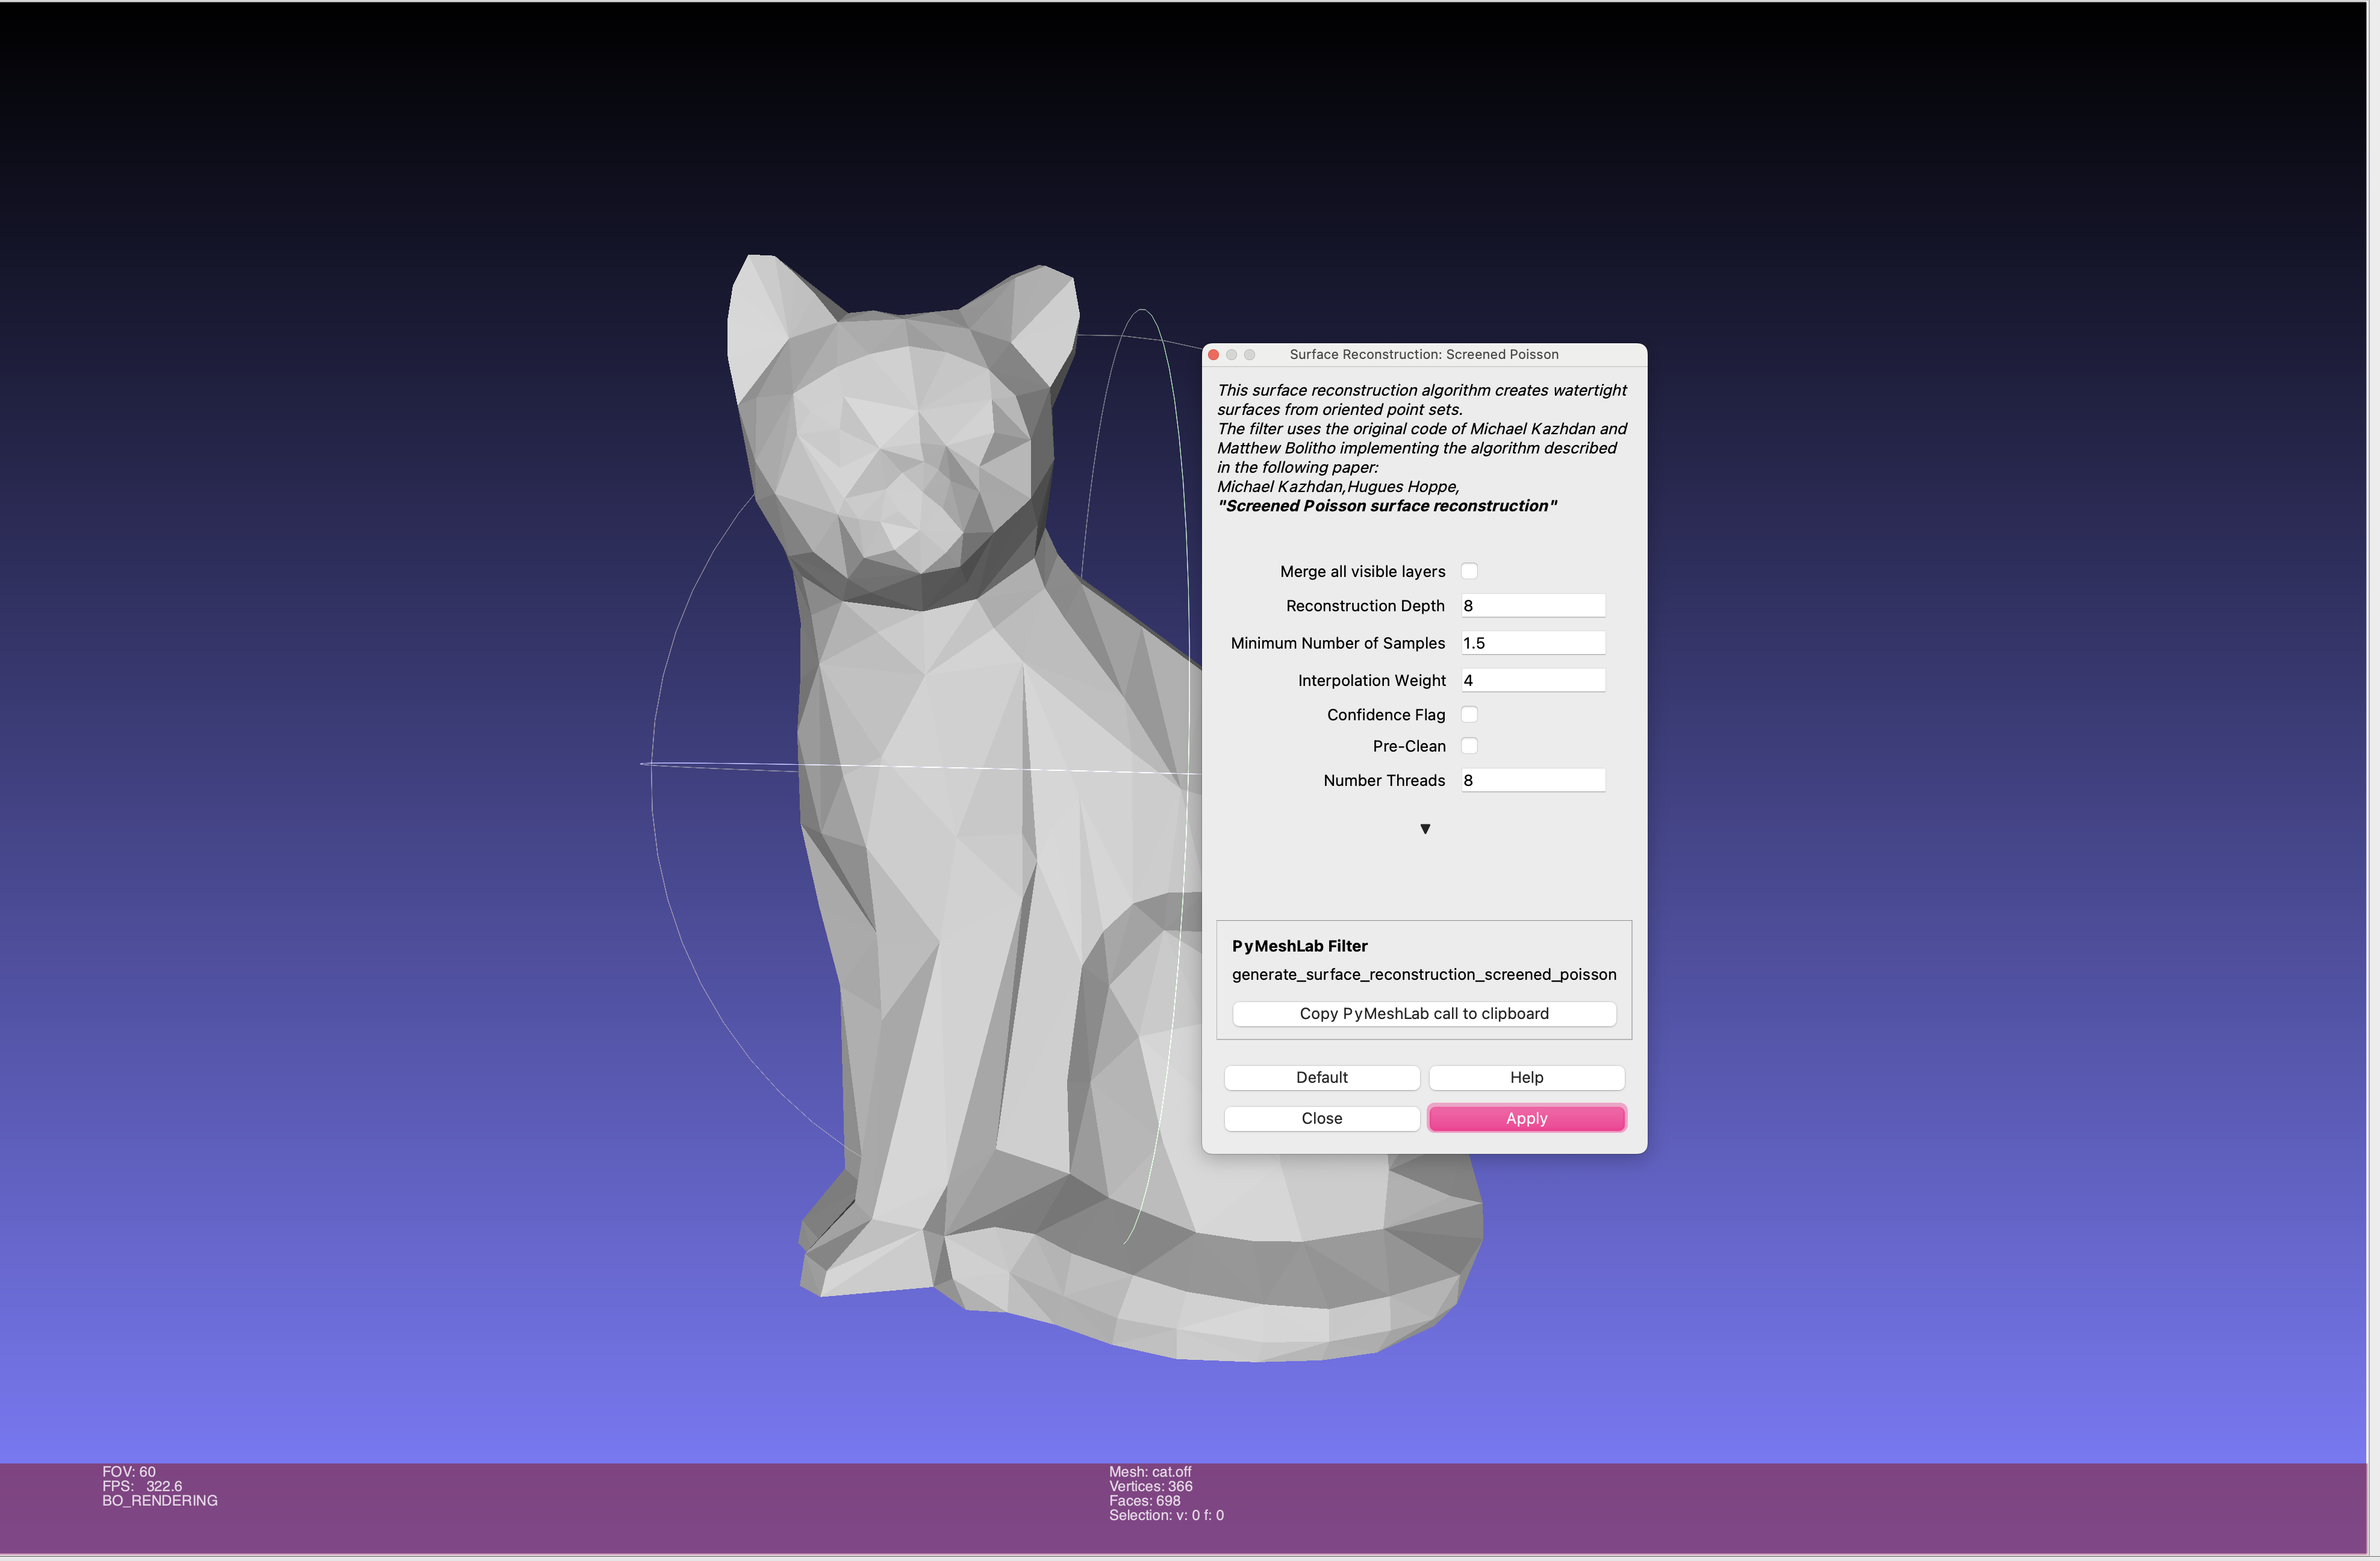

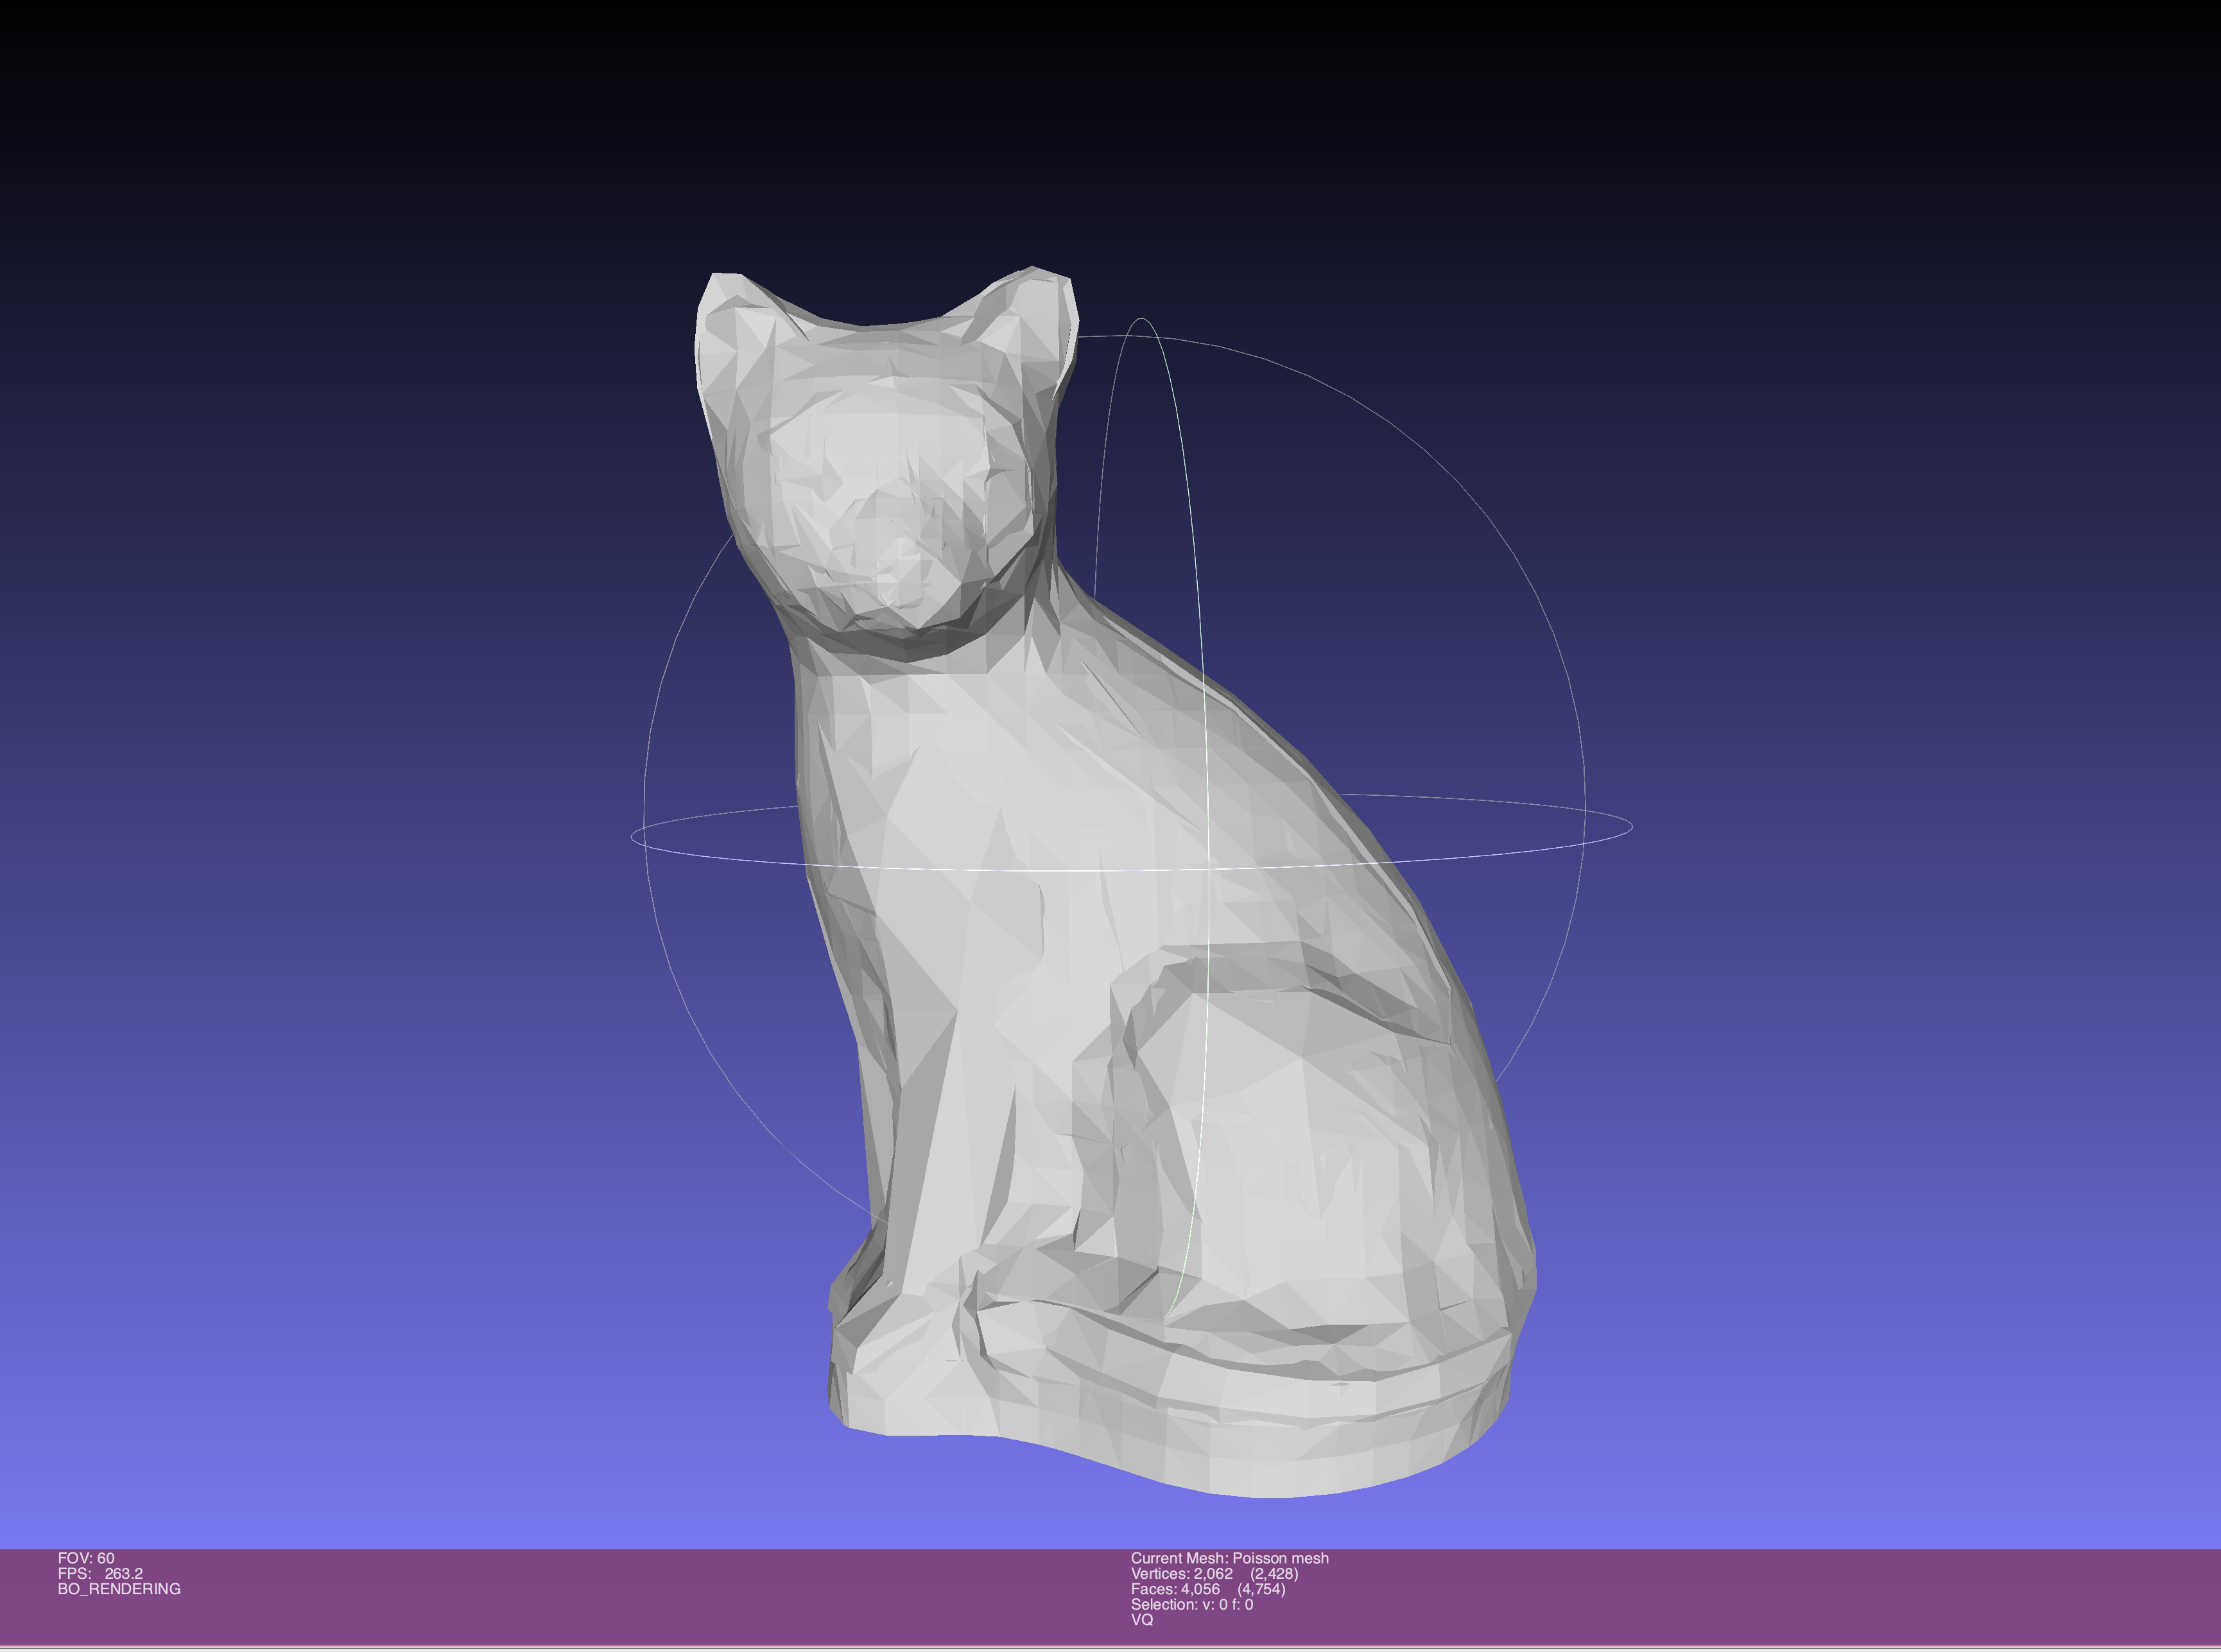


